In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
import string
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [2]:
stock_df = pd.read_csv("stock_sentiment.csv")

In [3]:
stock_df

Text  Sentiment
0     Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1
1     user: AAP MOVIE. 55% return for the FEA/GEED i...          1
2     user I'd be afraid to short AMZN - they are lo...          1
3                                     MNTA Over 12.00            1
4                                      OI  Over 21.37            1
...                                                 ...        ...
5786  Industry body CII said #discoms are likely to ...          0
5787  #Gold prices slip below Rs 46,000 as #investor...          0
5788  Workers at Bajaj Auto have agreed to a 10% wag...          1
5789  #Sharemarket LIVE: Sensex off day’s high, up 6...          1
5790  #Sensex, #Nifty climb off day's highs, still u...          1

[5791 rows x 2 columns]

In [4]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [5]:
stock_df.isnull().sum()

Text         0
Sentiment    0
dtype: int64

## Removing Punctuations from text



In [6]:
#Function to remove punctuations
def remove_punc(message):
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)

    return Test_punc_removed_join

In [7]:
stock_df['Text Without Punctuation'] = stock_df['Text'].apply(remove_punc)

In [8]:
stock_df

Text  Sentiment  \
0     Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1   
1     user: AAP MOVIE. 55% return for the FEA/GEED i...          1   
2     user I'd be afraid to short AMZN - they are lo...          1   
3                                     MNTA Over 12.00            1   
4                                      OI  Over 21.37            1   
...                                                 ...        ...   
5786  Industry body CII said #discoms are likely to ...          0   
5787  #Gold prices slip below Rs 46,000 as #investor...          0   
5788  Workers at Bajaj Auto have agreed to a 10% wag...          1   
5789  #Sharemarket LIVE: Sensex off day’s high, up 6...          1   
5790  #Sensex, #Nifty climb off day's highs, still u...          1   

                               Text Without Punctuation  
0     Kickers on my watchlist XIDE TIT SOQ PNK CPW B...  
1     user AAP MOVIE 55 return for the FEAGEED indic...  
2     user Id be afraid to short AMZN  they are look...  
3                                      MNTA Over 1200    
4                                       OI  Over 2137    
...                                                 ...  
5786  Industry body CII said discoms are likely to s...  
5787  Gold prices slip below Rs 46000 as investors b...  
5788  Workers at Bajaj Auto have agreed to a 10 wage...  
5789  Sharemarket LIVE Sensex off day’s high up 600 ...  
5790  Sensex Nifty climb off days highs still up 2 K...  

[5791 rows x 3 columns]

In [9]:
stock_df['Text'][2]

"user I'd be afraid to short AMZN - they are looking like a near-monopoly in eBooks and infrastructure-as-a-service"

In [10]:
stock_df['Text Without Punctuation'][2]

'user Id be afraid to short AMZN  they are looking like a nearmonopoly in eBooks and infrastructureasaservice'

## Removing stopwords

In [11]:
# downloading stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stas1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
# Obtaining more from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','will','aap','co','day','user','stock','today','week','year', 'https'])


In [13]:
# Removing stopwords and short words
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) >= 3 and token not in stop_words:
            result.append(token)
            
    return result

In [14]:
# apply pre-processing to the text column
stock_df['Text Without Punc & Stopwords'] = stock_df['Text Without Punctuation'].apply(preprocess)

In [15]:
stock_df['Text'][0]

'Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ  trade method 1 or method 2, see prev posts'

In [16]:
stock_df['Text Without Punc & Stopwords'][0]

['kickers',
 'watchlist',
 'xide',
 'tit',
 'soq',
 'pnk',
 'cpw',
 'bpz',
 'trade',
 'method',
 'method',
 'see',
 'prev',
 'posts']

In [17]:
stock_df

Text  Sentiment  \
0     Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1   
1     user: AAP MOVIE. 55% return for the FEA/GEED i...          1   
2     user I'd be afraid to short AMZN - they are lo...          1   
3                                     MNTA Over 12.00            1   
4                                      OI  Over 21.37            1   
...                                                 ...        ...   
5786  Industry body CII said #discoms are likely to ...          0   
5787  #Gold prices slip below Rs 46,000 as #investor...          0   
5788  Workers at Bajaj Auto have agreed to a 10% wag...          1   
5789  #Sharemarket LIVE: Sensex off day’s high, up 6...          1   
5790  #Sensex, #Nifty climb off day's highs, still u...          1   

                               Text Without Punctuation  \
0     Kickers on my watchlist XIDE TIT SOQ PNK CPW B...   
1     user AAP MOVIE 55 return for the FEAGEED indic...   
2     user Id be afraid to short AMZN  they are look...   
3                                      MNTA Over 1200     
4                                       OI  Over 2137     
...                                                 ...   
5786  Industry body CII said discoms are likely to s...   
5787  Gold prices slip below Rs 46000 as investors b...   
5788  Workers at Bajaj Auto have agreed to a 10 wage...   
5789  Sharemarket LIVE Sensex off day’s high up 600 ...   
5790  Sensex Nifty climb off days highs still up 2 K...   

                          Text Without Punc & Stopwords  
0     [kickers, watchlist, xide, tit, soq, pnk, cpw,...  
1     [movie, return, feageed, indicator, trades, aw...  
2     [afraid, short, amzn, looking, like, nearmonop...  
3                                                [mnta]  
4                                                    []  
...                                                 ...  
5786  [industry, body, cii, said, discoms, likely, s...  
5787  [gold, prices, slip, investors, book, profits,...  
5788  [workers, bajaj, auto, agreed, wage, cut, peri...  
5789  [sharemarket, live, sensex, high, points, nift...  
5790  [sensex, nifty, climb, days, highs, still, key...  

[5791 rows x 4 columns]

## Plotting WordCloud

In [18]:
# joining the words into a string
stock_df['Text Without Punc & Stopwords Joined'] = stock_df['Text Without Punc & Stopwords'].apply(lambda x: " ".join(x))

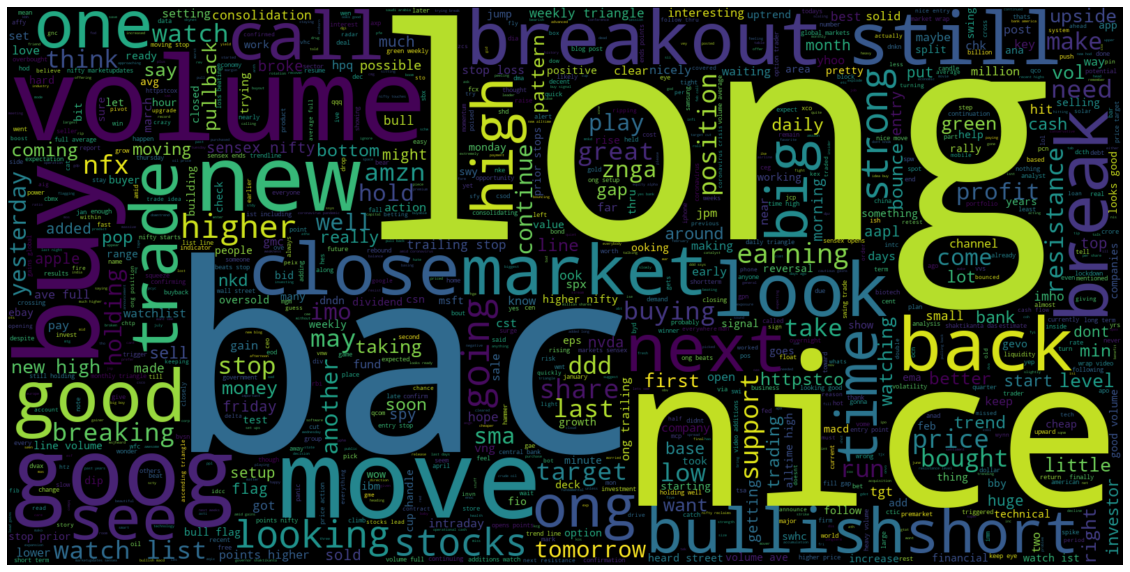

In [19]:
#Positive Sentiment
plt.figure(figsize = (20, 20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(stock_df[stock_df['Sentiment'] == 1]['Text Without Punc & Stopwords Joined']))
plt.axis('off')
#plt.savefig('Wordcloud_Positive.png')
plt.imshow(wc, interpolation = 'bilinear')


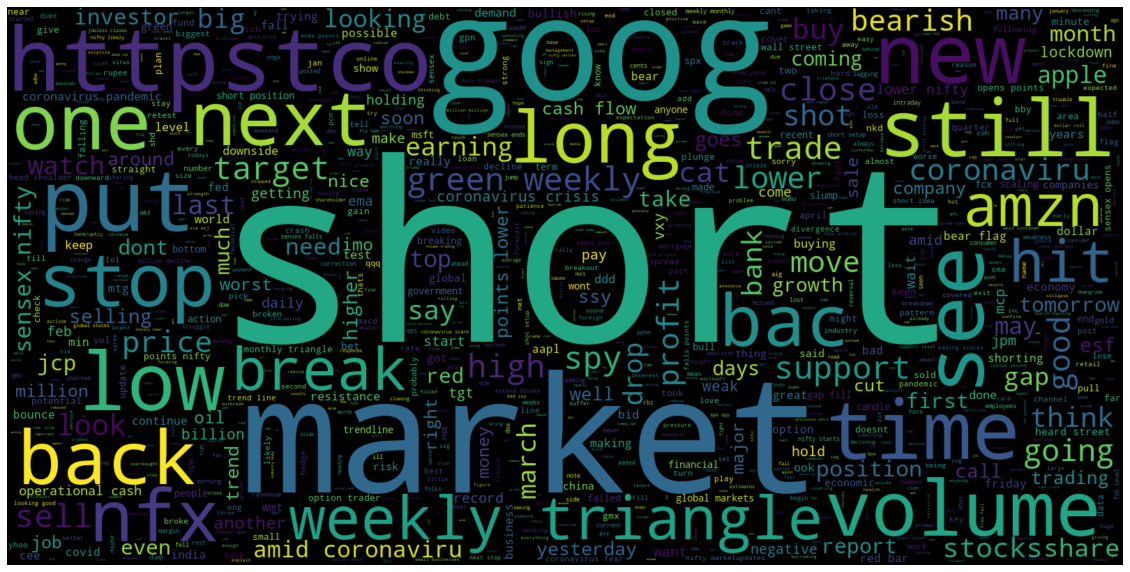

In [20]:
#Negative Sentiment
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 1000, width = 1600, height = 800 ).generate(" ".join(stock_df[stock_df['Sentiment'] == 0]['Text Without Punc & Stopwords Joined']))
plt.axis('off')
#plt.savefig('Wordcloud_Negative.png')
plt.imshow(wc, interpolation = 'bilinear')

In [21]:
stock_df

Text  Sentiment  \
0     Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1   
1     user: AAP MOVIE. 55% return for the FEA/GEED i...          1   
2     user I'd be afraid to short AMZN - they are lo...          1   
3                                     MNTA Over 12.00            1   
4                                      OI  Over 21.37            1   
...                                                 ...        ...   
5786  Industry body CII said #discoms are likely to ...          0   
5787  #Gold prices slip below Rs 46,000 as #investor...          0   
5788  Workers at Bajaj Auto have agreed to a 10% wag...          1   
5789  #Sharemarket LIVE: Sensex off day’s high, up 6...          1   
5790  #Sensex, #Nifty climb off day's highs, still u...          1   

                               Text Without Punctuation  \
0     Kickers on my watchlist XIDE TIT SOQ PNK CPW B...   
1     user AAP MOVIE 55 return for the FEAGEED indic...   
2     user Id be afraid to short AMZN  they are look...   
3                                      MNTA Over 1200     
4                                       OI  Over 2137     
...                                                 ...   
5786  Industry body CII said discoms are likely to s...   
5787  Gold prices slip below Rs 46000 as investors b...   
5788  Workers at Bajaj Auto have agreed to a 10 wage...   
5789  Sharemarket LIVE Sensex off day’s high up 600 ...   
5790  Sensex Nifty climb off days highs still up 2 K...   

                          Text Without Punc & Stopwords  \
0     [kickers, watchlist, xide, tit, soq, pnk, cpw,...   
1     [movie, return, feageed, indicator, trades, aw...   
2     [afraid, short, amzn, looking, like, nearmonop...   
3                                                [mnta]   
4                                                    []   
...                                                 ...   
5786  [industry, body, cii, said, discoms, likely, s...   
5787  [gold, prices, slip, investors, book, profits,...   
5788  [workers, bajaj, auto, agreed, wage, cut, peri...   
5789  [sharemarket, live, sensex, high, points, nift...   
5790  [sensex, nifty, climb, days, highs, still, key...   

                   Text Without Punc & Stopwords Joined  
0     kickers watchlist xide tit soq pnk cpw bpz tra...  
1         movie return feageed indicator trades awesome  
2     afraid short amzn looking like nearmonopoly eb...  
3                                                  mnta  
4                                                        
...                                                 ...  
5786  industry body cii said discoms likely suffer n...  
5787  gold prices slip investors book profits amid c...  
5788  workers bajaj auto agreed wage cut period apri...  
5789  sharemarket live sensex high points nifty test...  
5790  sensex nifty climb days highs still key factor...  

[5791 rows x 5 columns]

In [22]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stas1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
# word_tokenize is used to break up a string into words
print(stock_df['Text Without Punc & Stopwords Joined'][0])
print(nltk.word_tokenize(stock_df['Text Without Punc & Stopwords Joined'][0]))

kickers watchlist xide tit soq pnk cpw bpz trade method method see prev posts
['kickers', 'watchlist', 'xide', 'tit', 'soq', 'pnk', 'cpw', 'bpz', 'trade', 'method', 'method', 'see', 'prev', 'posts']


In [24]:
# Obtaining the maximum length of data in the document
maxlen = -1
for doc in stock_df['Text Without Punc & Stopwords Joined']:
    tokens = nltk.word_tokenize(doc)
    if(maxlen < len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is:", maxlen)

The maximum number of words in any document is: 20


In [25]:
tweets_length = [ len(nltk.word_tokenize(x)) for x in stock_df['Text Without Punc & Stopwords Joined'] ]
tweets_length

[14,
 6,
 7,
 1,
 0,
 1,
 8,
 13,
 8,
 4,
 10,
 18,
 8,
 8,
 11,
 5,
 12,
 10,
 12,
 4,
 6,
 5,
 2,
 5,
 3,
 10,
 3,
 3,
 9,
 6,
 8,
 10,
 8,
 3,
 10,
 11,
 4,
 8,
 11,
 10,
 10,
 7,
 9,
 8,
 4,
 10,
 8,
 7,
 7,
 9,
 10,
 10,
 8,
 2,
 14,
 12,
 9,
 8,
 1,
 14,
 7,
 11,
 5,
 13,
 6,
 6,
 7,
 6,
 6,
 10,
 9,
 4,
 10,
 13,
 16,
 6,
 9,
 6,
 2,
 11,
 5,
 4,
 9,
 11,
 16,
 4,
 9,
 5,
 6,
 2,
 1,
 5,
 9,
 4,
 7,
 6,
 7,
 10,
 1,
 3,
 9,
 4,
 16,
 8,
 10,
 11,
 18,
 6,
 7,
 13,
 12,
 9,
 3,
 3,
 10,
 10,
 8,
 6,
 8,
 5,
 5,
 8,
 9,
 15,
 3,
 5,
 9,
 18,
 13,
 11,
 3,
 1,
 1,
 2,
 7,
 12,
 12,
 8,
 8,
 10,
 9,
 10,
 15,
 8,
 9,
 9,
 12,
 10,
 6,
 10,
 13,
 4,
 11,
 8,
 15,
 13,
 8,
 12,
 5,
 5,
 3,
 7,
 2,
 4,
 10,
 5,
 6,
 10,
 6,
 16,
 9,
 6,
 5,
 10,
 9,
 10,
 8,
 2,
 10,
 9,
 10,
 12,
 7,
 10,
 7,
 3,
 6,
 5,
 9,
 9,
 4,
 6,
 5,
 4,
 4,
 8,
 10,
 8,
 8,
 13,
 9,
 7,
 10,
 12,
 8,
 6,
 5,
 3,
 10,
 11,
 6,
 9,
 10,
 13,
 10,
 7,
 12,
 7,
 11,
 10,
 4,
 4,
 3,
 10,
 2,
 9,
 10,
 15,
 12,
 10

In [26]:
# Plotting the distribution for the number of words in a text
fig = px.histogram(x = tweets_length, nbins = 50, labels={'x':'Length of a tweet in words'}, title='Histogram of number words in a tweet')
#fig.write_image("Histogram of number words in a tweet.png")
fig.show()

In [27]:
# Obtaining the total words present in the dataset
list_of_words = []
for i in stock_df['Text Without Punc & Stopwords']:
    for j in i:
        list_of_words.append(j)


In [28]:
# Obtaining the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

9268

In [29]:
# splitting the data into test and train 
X = stock_df['Text Without Punc & Stopwords']
y = stock_df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [30]:
X_train.shape

(5211,)

In [31]:
X_test.shape

(580,)

In [32]:
X_train

4281    [quietly, show, consistent, every, min, print,...
3829    [shorting, cog, xco, cog, far, dma, think, pul...
4402           [tagging, could, another, points, mileage]
4223    [rest, still, long, shares, account, another, ...
4929    [final, shakeout, earnings, long, using, tight...
                              ...                        
3580    [bot, puts, dead, cat, bounce, free, fall, con...
2047    [scratching, head, goes, shale, refiner, profi...
3718    [swhc, killed, earnings, still, matter, patien...
3873    [opens, door, deal, china, mobile, sad, building]
562     [doji, like, candle, close, may, signify, poss...
Name: Text Without Punc & Stopwords, Length: 5211, dtype: object

In [33]:
# Creating a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(X_train)

# Training data
train_sequences = tokenizer.texts_to_sequences(X_train)

# Testing data
test_sequences = tokenizer.texts_to_sequences(X_test)


In [34]:
print("The encoding for document\n", X_train[1:2],"\n is: ", train_sequences[1])

The encoding for document
 3829    [shorting, cog, xco, cog, far, dma, think, pul...
Name: Text Without Punc & Stopwords, dtype: object 
 is:  [481, 704, 454, 704, 234, 482, 59, 1117, 13, 482, 199, 2476, 216]


In [35]:
# Adding padding to training and testing
padded_train = pad_sequences(train_sequences, maxlen = 29, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = 29, truncating = 'post')

In [36]:
for i, doc in enumerate(padded_train[:3]):
     print("The padded encoding for document:", i+1," is:", doc)

The padded encoding for document: 1  is: [1890  480 2475  410  145 1280 1891   13   65  971 1892  411    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
The padded encoding for document: 2  is: [ 481  704  454  704  234  482   59 1117   13  482  199 2476  216    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
The padded encoding for document: 3  is: [3626   29   86   42 3627    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [37]:
# Converting the data to categorical 2D representation
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

In [38]:
y_train_cat.shape

(5211, 2)

In [39]:
y_test_cat.shape

(580, 2)

In [40]:
y_train_cat

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [41]:
# Adding padding to training and testing
padded_train = pad_sequences(train_sequences, maxlen = 15, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = 15, truncating = 'post')

In [42]:
# Sequential Model
model = Sequential()

# embedding layer
model.add(Embedding(total_words, output_dim = 512))

# Bi-Directional RNN and LSTM
model.add(LSTM(256))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 512)         4745216   
                                                                 
 lstm (LSTM)                 (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 5,565,826
Trainable params: 5,565,826
Non-trainable params: 0
_________________________________________________________________


In [43]:
# training the model
model.fit(padded_train, y_train_cat, batch_size = 32, validation_split = 0.2, epochs = 2)

Epoch 1/2
131/131 [==============================] - 19s 129ms/step - loss: 0.5663 - acc: 0.7090 - val_loss: 0.5220 - val_acc: 0.7181
Epoch 2/2
131/131 [==============================] - 16s 121ms/step - loss: 0.2934 - acc: 0.8839 - val_loss: 0.5234 - val_acc: 0.7392


In [44]:
# making prediction
pred = model.predict(padded_test)

In [45]:
# making prediction
prediction = []
for i in pred:
    prediction.append(np.argmax(i))

In [46]:
# list containing original values
original = []
for i in y_test_cat:
    original.append(np.argmax(i))

In [47]:
# acuracy score on text data

accuracy = accuracy_score(original, prediction)
accuracy

0.7396551724137931

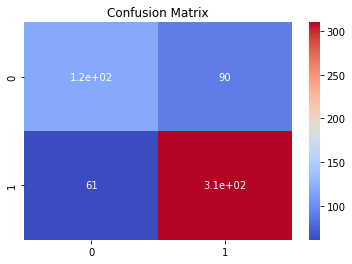

In [49]:
# Plotting the confusion matrix
cm = confusion_matrix(original, prediction)
ax=plt.axes()
sns.heatmap(cm, annot = True, cmap='coolwarm')
ax.set_title('Confusion Matrix')
plt.savefig('Confusion_Matrix', bbox_inches='tight')
plt.show()